In [1]:
%pylab inline
import geopandas as gpd
import pandas as pd
import os
# !pip install mplleaflet
import mplleaflet


Populating the interactive namespace from numpy and matplotlib


In [2]:
fish_pass = 'ADFG/ADFG_fish_passage.shp'
fp = gpd.read_file(fish_pass)
regs = 'HUC8_rebuild/output/sasap_regions.shp'
regions = gpd.read_file(regs)

In [3]:
fp = fp.to_crs(epsg=3338)
regions = regions.to_crs(epsg=3338)

Each FP_color represents a fish passage impact rating (listed under RGGRating). I want to get eventually get counts of FP_color per region from regions gdf. Then map these in some way (or multiple ways).

In [6]:
fp.RGGRating.head()

0      Red
1    Green
2      Red
3    Green
4      Red
Name: RGGRating, dtype: object

In [7]:
fp2 = fp[['geometry', 'RGGRating']]

In [14]:
%%time
reg_rgg = gpd.sjoin(fp2, regions, op='within').drop('index_right', axis='columns')

CPU times: user 278 ms, sys: 13.3 ms, total: 291 ms
Wall time: 290 ms


In [11]:
reg_rgg.count()

geometry       2929
RGGRating      2927
index_right    2929
region_id      2929
region         2929
dtype: int64

In [12]:
fp2.count()

geometry     2930
RGGRating    2928
dtype: int64

In [15]:
reg_rgg.head()

,geometry,RGGRating,region_id,region
0,POINT (83811.68299580242 819266.9230174191),Red,6,Kodiak
2220,POINT (80366.30333690392 874133.2270201525),Gray,6,Kodiak
2221,POINT (79595.26420932778 873985.3460359153),Red,6,Kodiak
2222,POINT (91562.86612378767 871690.9983501389),Red,6,Kodiak
2223,POINT (81048.90137418527 871092.781904645),Black,6,Kodiak


In [25]:
foo = reg_rgg.drop('region_id', axis='columns').groupby(['region','RGGRating'])

You should figure out how to fill `NaN`s with `0`. Then you should also be able to convert those columns (Black, Gray, etc) to integer.

In [72]:
bar = foo.count()
blah = bar.unstack('RGGRating')
blah.columns = blah.columns.get_level_values(1)
# blah.assign(region=blah.index)
blah2 = blah.join(regions.set_index('region'), on='region', how='outer')
blah2

,Black,Gray,Green,Red,region_id,geometry
region,,,,,,
Aleutian Islands,48.0,22.0,8.0,32.0,1,(POLYGON ((-1156665.959195634 420855.093106978...
Arctic,3.0,8.0,13.0,8.0,2,"POLYGON ((571289.9424044377 2143072.479559345,..."
Bristol Bay,6.0,7.0,5.0,7.0,3,(POLYGON ((-339688.5870041371 973904.876117813...
Cook Inlet,72.0,213.0,302.0,474.0,9,"(POLYGON ((35214.97605528703 1002456.87086566,..."
Copper River,NaN,62.0,31.0,112.0,5,"POLYGON ((561012.0068005103 1148300.750064242,..."
Kodiak,75.0,25.0,22.0,67.0,6,(POLYGON ((115112.5187827438 983292.9990368463...
Norton Sound,2.0,19.0,9.0,76.0,10,(POLYGON ((-848356.9600070229 1636692.01922057...
Prince William Sound,4.0,17.0,6.0,16.0,11,(POLYGON ((426007.0728565209 1087250.373112139...
Southeast,35.0,193.0,201.0,296.0,12,(POLYGON ((1287776.763303712 744574.0859671865...


Save to csv:

In [73]:
blah2.drop('geometry', axis='columns').to_csv('fp_regions.csv')

Save to shapefile:

To do: 

- set crs before saving 
- copy index to region column

In [75]:
gpd.GeoDataFrame(blah2).to_file('fp_regions.shp')

Make a few pretty(er) plots in the notebook. This should work once you've filled the `NaN`s and converted to int.

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/usr/local/lib/python2.7/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


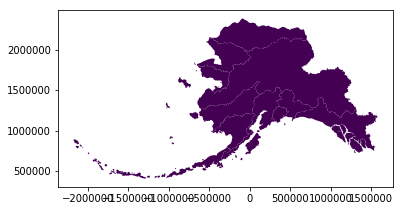

In [74]:
gpd.GeoDataFrame(blah2).plot('Gray')

In [20]:
fp2.RGGRating.value_counts()

Red      1295
Green     720
Gray      638
Black     275
Name: RGGRating, dtype: int64

In [5]:
fp['FP_red'] = fp['RGGRating'] == 'Red'
fp['FP_green'] = fp['RGGRating'] == 'Green'
fp['FP_gray'] = fp['RGGRating'] == 'Gray'
fp['FP_black'] = fp['RGGRating'] == 'Black'

Created a new gdf *RGG*

In [6]:
RGG = fp[['geometry','FP_red', 'FP_green', 'FP_gray', 'FP_black']]
RGG.head()

,geometry,FP_red,FP_green,FP_gray,FP_black
0,POINT (83811.68299580242 819266.9230174191),True,False,False,False
1,POINT (213872.4420121688 2252881.915418045),False,True,False,False
2,POINT (213536.4334304724 2250613.46924101),True,False,False,False
3,POINT (207221.6008933302 2235195.704555049),False,True,False,False
4,POINT (210232.879883608 2156742.824674348),True,False,False,False


Find points within each region

In [7]:
for reg in regions.region: 
    sub_gdf = regions.query("region==@reg") 
    geom_ser = sub_gdf.geometry # here we are getting a series of geometries (geometry already part of gdf)
    geom = geom_ser.iloc[0] # here is our geometry object, iloc based on interger location based on indexing for selection by position
    RGG[reg] = RGG.within(geom)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [8]:
RGG.head()

,geometry,FP_red,FP_green,FP_gray,FP_black,Aleutian Islands,Arctic,Bristol Bay,Chignik,Copper River,Kodiak,Kotzebue,Kuskokwim,Cook Inlet,Norton Sound,Prince William Sound,Southeast,Yukon
0,POINT (83811.68299580242 819266.9230174191),True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,POINT (213872.4420121688 2252881.915418045),False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,POINT (213536.4334304724 2250613.46924101),True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,POINT (207221.6008933302 2235195.704555049),False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,POINT (210232.879883608 2156742.824674348),True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


I want to now get counts of each impact (colors) per region

In [12]:
# RGG has the impact for each geometry, does it have the geometry object, I imagine it does I just don't see that?
RGG['Red_Kodiak'] = np.where((RGG['FP_red'] == True) & (RGG['Kodiak'] == True), True, False)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
# Alternative
RGG.loc[:,'Red_Kodiak2'] = False
RGG.loc[RGG.FP_red & RGG.Kodiak, 'Red_Kodiak2'] = True

In [18]:
(RGG.Red_Kodiak == RGG.Red_Kodiak2).all()

True

In [12]:
RGG['Red_Kodiak'].head()

0     True
1    False
2    False
3    False
4    False
Name: Red_Kodiak, dtype: bool

In [13]:
RGG['Red_Kodiak'].sum()

67

I could continue to do this manually for each color and region but that would be a pain and inefficient. 

In [17]:
# may need to leave RGG as a series? 
# maybe I need to iterate over multiple columns?
for i, row in RGG.iterrows(): # maybe categorize these by geometry within this gdf? then move onto regions
    np.where()
    print(i, row)
#     for r, c in # there are 13? regions seems like a lot to type

(0, geometry                POINT (83811.68299580242 819266.9230174191)
FP_red                                                         True
FP_green                                                      False
FP_gray                                                       False
FP_black                                                      False
Aleutian Islands                                              False
Arctic                                                        False
Bristol Bay                                                   False
Chignik                                                       False
Copper River                                                  False
Kodiak                                                         True
Kotzebue                                                      False
Kuskokwim                                                     False
Cook Inlet                                                    False
Norton Sound                                

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(2837, geometry                POINT (-525897.0210170092 599814.6752202375)
FP_red                                                         False
FP_green                                                        True
FP_gray                                                        False
FP_black                                                       False
Aleutian Islands                                                True
Arctic                                                         False
Bristol Bay                                                    False
Chignik                                                        False
Copper River                                                   False
Kodiak                                                         False
Kotzebue                                                       False
Kuskokwim                                                      False
Cook Inlet                                                     False
Norton Sound               

In [22]:
for key,value in RGG.iteritems():
   print key, value[5]

geometry POINT (209664.0374586324 2154568.821857522)
FP_red False
FP_green True
FP_gray False
FP_black False
Aleutian Islands False
Arctic True
Bristol Bay False
Chignik False
Copper River False
Kodiak False
Kotzebue False
Kuskokwim False
Cook Inlet False
Norton Sound False
Prince William Sound False
Southeast False
Yukon False
Red_Kodiak False


In [ ]:
for color in regions.region:
    n_mines = mines[reg].sum()
    regions.loc[regions.region==reg, 'n_mines'] = n_mines

In [23]:
count = {}
colors = RGG.columns[1:5].tolist()
regions = RGG.columns[5:].tolist()
for region in regions:
    d = RGG[RGG[region]][colors].sum()
    count[region] = d

In [25]:
colors

['FP_red', 'FP_green', 'FP_gray', 'FP_black']

In [26]:
type(regions)

list

In [27]:
type(d)

pandas.core.series.Series

In [28]:
d

FP_red      67
FP_green     0
FP_gray      0
FP_black     0
dtype: int64